In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegem1d import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, get_vertical_discretization_time, EM1DSurveyTD
)
from pymatsolver import PardisoSolver
def get_geotem_wave(pulse_period, n_segment=3):
    t = 0.
    T = pulse_period
    time_input_currents = np.r_[0., T/2., np.linspace(3*T/4., T, n_segment)]
    input_currents = np.sin(np.pi/T*time_input_currents)
    return time_input_currents, input_currents

def get_nanotem_wave(ramp_off_time, ntime=None):
    time_input_currents = np.r_[0, ramp_off_time]
    input_currents = np.r_[1, 0.]    
    return time_input_currents, input_currents

time_input_currents_geotem, input_currents_geotem = get_geotem_wave(4096*1e-6)
ramp_off_time = 5e-6
time_input_currents_nanotem, input_currents_nanotem = get_nanotem_wave(ramp_off_time)
time_geotem = np.logspace(-4, -2, 10)
time_nanotem = np.logspace(-6, -4, 15)
hz = get_vertical_discretization_time(np.r_[time_geotem, time_nanotem], facter_tmax=0.5, factor_tmin=10., sigma_background=1./15.)

In [2]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

n_sounding = 10
n_sounding_geotem = 9
n_sounding_nanotem = n_sounding - n_sounding_geotem
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds = np.logical_and(mesh.gridCC[:,1]>10, mesh.gridCC[:,1]<30.) 
sigma = np.ones(mesh.nC) * 1./15.
sigma[inds] = 1./100.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 90.]
x2 = np.r_[dx*n_sounding, 90.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 1./15.
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()

x = mesh.vectorCCx[:n_sounding_geotem]
y = np.zeros_like(x)
z = np.ones_like(x) * 120.
rx_locations_geotem = np.c_[x, y, z-45.]
src_locations_geotem = np.c_[x, y, z]
topo_geotem = np.c_[x, y, z-120.].astype(float)

x = mesh.vectorCCx[n_sounding_geotem:]
y = np.zeros_like(x)
z = np.ones_like(x) * 0.
rx_locations_nanotem = np.c_[x, y, z]
src_locations_nanotem = np.c_[x, y, z]
topo_nanotem = np.c_[x, y, z].astype(float)

src_locations = np.vstack((src_locations_geotem, src_locations_nanotem))
rx_locations = np.vstack((rx_locations_geotem, rx_locations_nanotem))
topo = np.vstack((topo_geotem, topo_nanotem))

In [3]:
n_sounding_geotem=rx_locations_geotem.shape[0]
n_sounding_nanotem=rx_locations_nanotem.shape[0]
n_sounding = n_sounding_geotem + n_sounding_nanotem

In [4]:
mapping = Maps.ExpMap(mesh)
rx_type_global = np.array(["dBzdt"], dtype=str).repeat(n_sounding, axis=0)
field_type_global = np.array(['secondary'], dtype=str).repeat(n_sounding, axis=0)
wave_type_global = np.array(['general'], dtype=str).repeat(n_sounding, axis=0)

time_geotem_all = [time_geotem for i in range(n_sounding_geotem)]
time_nanotem_all = [time_nanotem for i in range(n_sounding_nanotem)]
time_global = time_geotem_all + time_nanotem_all

src_type_geotem_all = np.array(["VMD"], dtype=str).repeat(n_sounding_geotem, axis=0)
src_type_nanotem_all = np.array(["CircularLoop"], dtype=str).repeat(n_sounding_nanotem, axis=0)
src_type_global = np.r_[src_type_geotem_all, src_type_nanotem_all]

a_global = np.array([13.], dtype=float).repeat(n_sounding, axis=0)
offset_global = np.array([120.], dtype=float).repeat(n_sounding, axis=0)

input_currents_geotem_all = [input_currents_geotem for i in range(n_sounding_geotem)]
input_currents_nanotem_all = [input_currents_nanotem for i in range(n_sounding_nanotem)]
input_currents_global = input_currents_geotem_all + input_currents_nanotem_all

time_input_currents_geotem_all = [time_input_currents_geotem for i in range(n_sounding_geotem)]
time_input_currents_nanotem_all = [time_input_currents_nanotem for i in range(n_sounding_nanotem)]
time_input_currents_global = time_input_currents_geotem_all + time_input_currents_nanotem_all

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = time_global,
    src_type = src_type_global,
    rx_type = rx_type_global,    
    field_type = field_type_global,
    wave_type = wave_type_global,    
    a = a_global,
    input_currents=input_currents_global,
    time_input_currents=time_input_currents_global
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True,n_cpu=2,verbose=True,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 2


# Seting up a 2D mesh and model

In [5]:
%%time
m = np.log(sigma_em1d)
dobs = survey.makeSyntheticData(m, std=0.05, force=True)

Compute fields
CPU times: user 14.7 ms, sys: 17.5 ms, total: 32.2 ms
Wall time: 1.55 s


Populating the interactive namespace from numpy and matplotlib


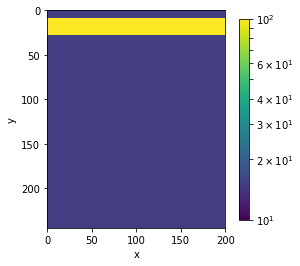

In [6]:
%pylab inline
cb = plt.colorbar(
    mesh.plotImage(1./sigma, grid=False, clim=(10., 100.),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [7]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)

In [8]:
mesh_reg = Mesh.TensorMesh([mesh.hy, mesh.hx])

In [9]:
%%time
std = 0.07
floor = 0.
np.random.seed(1)
uncert = std*abs(dobs)+floor
survey.dobs = dobs.copy()
m0 = np.ones(mesh.nC) * np.log(1./15.)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = Regularization.Sparse(
    mesh_reg, mapping=regmap,
    alpha_s=1.,
    alpha_x = 1.,
    alpha_y = 10.,    
)
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1, fix_Jmatrix=True,
    betaSearch=False
)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
update_sense = Directives.UpdateSensitivityWeights()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Compute fields


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:896: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


>> Compute J
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.72e+01  1.38e+03  0.00e+00  1.38e+03    1.52e+03      0              
Compute fields
>> Compute J
   1  8.60e+00  1.50e+02  4.31e+00  1.87e+02    1.70e+02      0              
Compute fields
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.8333691397830068 eps_q: 0.8333691397830068
>> Fix Jmatrix
Eps_p: 0.6944742831525057
Eps_q: 0.6944742831525057
delta phim:    inf
>> Compute J
   2  4.30e+00  4.55e+01  1.33e+01  1.03e+02    3.37e+01      0   Skip BFGS  
Compute fields
>> Fix Jmatrix
Eps_p: 0.5787285692937548
Eps_q: 0.5787285692937548
delta phim: 1.866e+00
   3  7.62e+00  3.39e+01  1.79e+01  1.70e+02    3.84e+01      0   Skip BFGS  
Compute fields
>> Fix Jmatrix

In [10]:
sigma_est = Utils.mkvc((np.exp(mopt)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l2 = Utils.mkvc((np.exp(invProb.l2model)).reshape((prob.n_sounding, prob.n_layer)))

In [11]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

Text(0.5,1,'Laterally-contrained model: L0 L2')

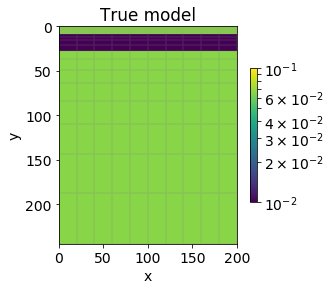

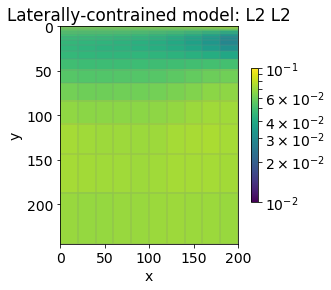

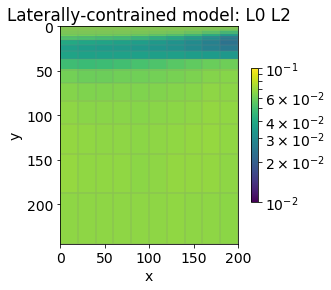

In [12]:
cb = plt.colorbar(
    mesh.plotImage(
        sigma, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

plt.title("True model")

cb = plt.colorbar(
    mesh.plotImage(
        sigma_est_l2, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.title("Laterally-contrained model: L2 L2")
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)


cb = plt.colorbar(
    mesh.plotImage(
        sigma_est, grid=True, clim=(1e-2, 1e-1), pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)
plt.title("Laterally-contrained model: L0 L2")

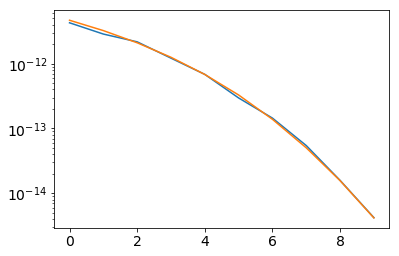

In [13]:
plt.semilogy(-dobs[survey.data_index[0]])
plt.semilogy(-invProb.dpred[survey.data_index[0]])

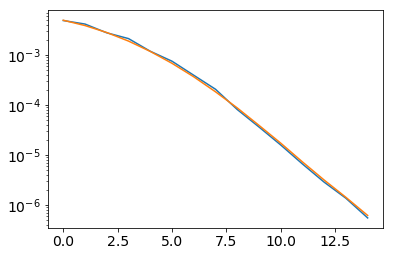

In [14]:
plt.semilogy(-dobs[survey.data_index[-1]])
plt.semilogy(-invProb.dpred[survey.data_index[-1]])